# Using Logistic Regression to find out Which Pokémon Generation Best Predicts Legendary Status Based on Base Stats 

### Packages

In [284]:
using CSV
using DataFrames
using GLM
using StatsBase 
using Plots  
using StatsPlots


### Reading in dataset

In [188]:
df = CSV.read("pokemon_dataset.csv", DataFrame)

Row,dex_number,name,type_01,type_02,ability_01,ability_02,hidden_ability,egg_group_01,egg_group_02,is_legendary,bio,hp,attack,defense,sp_attack,sp_defense,speed
,String7,String15,String15,String15?,String31,String31?,String31?,String31?,String?,Bool,String,Int64,Int64,Int64,Int64,Int64,Int64
1,#0001,Bulbasaur,Grass,Poison,Overgrow,missing,Chlorophyll,Monster,Grass,false,"Bulbasaur is a dual-type Grass/Poison Pokémon introduced in Generation I. It evolves into Ivysaur starting at level 16, which evolves into Venusaur starting at level 32. Along with Charmander and Squirtle, Bulbasaur is one of the three first partner Pokémon of Kanto available at the beginning of Pokémon Red, Green, Blue, FireRed, and LeafGreen. Bulbasaur is a small, quadrupedal amphibian Pokémon that has blue-green skin with darker patches. It has red eyes with white pupils, pointed, ear-like structures on top of its head, and a short, blunt snout with a wide mouth. A pair of small, pointed teeth are visible in the upper jaw when its mouth is open. Each of its thick legs ends with three sharp claws. On Bulbasaur's back is a green plant bulb that conceals two slender, tentacle-like vines, which is grown from a seed planted there at birth. The bulb also provides it with energy through photosynthesis as well as from the nutrient-rich seeds contained within. First partner Pokémon are raised by Breeders to be distributed to new Trainers. Having been raised by humans from birth, Bulbasaur is regarded as both a rare and well-behaved Pokémon. It is known to be extremely loyal, even after long-term abandonment. Bulbasaur have demonstrated a nurturing instinct towards younger, weaker Pokémon, one individual even using its vines to pick up a crying Pokémon, gently rocking it back and forth through the air while singing a ""Bulba-by"". Its vines are long and strong enough to allow Bulbasaur to grab the branches of trees and pull itself up to reach berries. Bulbasaur can survive for days without even eating a single morsel. As mentioned in Sleep Style Dex, Bulbasaur is known to sleep in sunny spots. It is found in grasslands and forests throughout the Kanto region. However, due to Bulbasaur's status as first partner Pokémon, it is hard to come by in the wild and generally found under the ownership of a Trainer. It has been recently seen living in the Terarium of Blueberry Academy. A Bulbasaur's bulb will flash blue when it is ready to evolve. If it does not want to evolve, it struggles to resist the transformation. Many Bulbasaur gather every year in a hidden garden in Kanto to evolve into Ivysaur in a ceremony led by a Venusaur.",45,49,49,65,65,45
2,#0002,Ivysaur,Grass,Poison,Overgrow,missing,Chlorophyll,Monster,Grass,false,"Ivysaur is a dual-type Grass/Poison Pokémon introduced in Generation I. It evolves from Bulbasaur starting at level 16 and evolves into Venusaur starting at level 32. Ivysaur is a quadrupedal amphibian Pokémon that has blue-green skin with darker patches. On top of its head are pointed ears with black insides and it has narrow red eyes. Ivysaur has a short, rounded snout with a wide mouth and two pointed teeth in its upper jaw. Each of its feet has three claws on them. The bulb on its back has bloomed into a large pink bud. A short brown trunk surrounded by leafy green fronds supports the bud. The weight of the plant prevents Ivysaur from running fast and standing on its hind legs, forcing its legs to grow sturdy. When its flower is ready to bloom, it gives off a distinct, sweet-smelling aroma and starts swelling. Ivysaur will also start spending more time in sunlight in preparation for its upcoming evolution. Exposure to sunlight adds to the strength of both Ivysaur and its plant. As shown in Pokémon Sleep, Ivysaur is known to sleep in sunny spots while undergoing its photosynthesis process. Researchers cannot decide if Ivysaur is awake or asleep during this process. Ivysaur are typically found in plains. Ivysaur evolves from Bulbasaur and evolves in

### Converting is_legendary columns to Int

In [191]:
df.is_legendary = convert.(Int, df.is_legendary)

1025-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 0
 0
 0
 0
 0
 0
 1
 0

### Creating Generation Column 


In [194]:

# Getting rid of # in front of every number 
df.National_Dex = parse.(Int, replace.(df.dex_number, "#" => ""))

# Now you can assign generations
df.Generation = similar(df.National_Dex)

for row in eachrow(df)
    num = row.National_Dex   
    if num <= 151
        row.Generation = 1
    elseif num <= 251
        row.Generation = 2
    elseif num <= 386
        row.Generation = 3
    elseif num <= 493
        row.Generation = 4
    elseif num <= 649
        row.Generation = 5
    elseif num <= 721
        row.Generation = 6
    elseif num <= 809
        row.Generation = 7
    elseif num <= 898
        row.Generation = 8
    else
        row.Generation = 9
    end
end

### Features

In [197]:
features = [:hp	:attack	:defense	:sp_attack	:sp_defense	:speed]
target = :is_legendary
# Filtering legendary Pokemon 
legendary_df = filter(row -> row.is_legendary == 1, df)

71×19 DataFrame
 Row │ dex_number  name         type_01   type_02    ability_01  ability_02  h ⋯
     │ String7     String15     String15  String15?  String31    String31?   S ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ #0144       Articuno     Ice        Flying    Pressure    missing     S ⋯
   2 │ #0145       Zapdos       Electric   Flying    Pressure    missing     S
   3 │ #0146       Moltres      Fire       Flying    Pressure    missing     F
   4 │ #0150       Mewtwo       Psychic   missing    Pressure    missing     U
   5 │ #0243       Raikou       Electric  missing    Pressure    missing     I ⋯
   6 │ #0244       Entei        Fire      missing    Pressure    missing     I
   7 │ #0245       Suicune      Water     missing    Pressure    missing     I
   8 │ #0249       Lugia        Psychic    Flying    Pressure    missing     M
   9 │ #0250       Ho-Oh        Fire       Flying    Pressure    missing     R ⋯
  10 │ #0377       Regirock     Rock      missing    Clear       missing     S
  11 │ #0378       Regice       Ice       missing    Clear       missing     I
  ⋮  │     ⋮            ⋮          ⋮          ⋮          ⋮           ⋮         ⋱
  62 │ #1002       Chien-Pao    Dark       Ice       Sword       missing     m
  63 │ #1003       Ting-Lu      Dark       Ground    Vessel      missing     m ⋯
  64 │ #1004       Chi-Yu       Dark       Fire      Beads       missing     m
  65 │ #1007       Koraidon     Fighting   Dragon    Orichalcum  missing     m
  66 │ #1008       Miraidon     Electric   Dragon    Hadron      missing     m
  67 │ #1014       Okidogi      Poison     Fighting  Toxic       missing     G ⋯
  68 │ #1015       Munkidori    Poison     Psychic   Toxic       missing     F
  69 │ #1016       Fezandipiti  Poison     Fairy     Toxic       missing     T
  70 │ #1017       Ogerpon      Grass     missing    Defiant     missing     m
  71 │ #1024       Terapagos    Normal    missing    Tera        missing     m ⋯
                                                  13 columns and 50 rows omitted

### Gen 1 Model 

In [200]:
gen1_df = filter(row -> row.Generation == 1, df)

# Fit logistic regression
formula = Term(:is_legendary) ~ sum(Term.(features))
model_gen1 = glm(formula, gen1_df, Binomial(), LogitLink())

# Predict probabilities for legendaries
legendary_df.prob_gen1 = predict(model_gen1, legendary_df)

# Optional: simple accuracy at 0.5 threshold
preds = legendary_df.prob_gen1 .>= 0.5
acc_1 = sum(preds .== legendary_df.is_legendary) / nrow(legendary_df)
println("Generation 1 model accuracy on legendaries: ", round(acc_1, digits=3))

Generation 1 model accuracy on legendaries: 0.493


In [202]:
### Makes sense, there were not that many legendary Pokemon in generation 1. 

### Gen 2 Model

In [205]:
gen2_df = filter(row -> row.Generation == 2, df)

# The model 
formula = Term(:is_legendary) ~ sum(Term.(features))
model_gen2 = glm(formula, gen2_df, Binomial(), LogitLink())

# Probabilities 
legendary_df.prob_gen2 = predict(model_gen2, legendary_df)

# Accuracy at 0.5 threshold 
preds = legendary_df.prob_gen2 .>= 0.5
acc_2 = sum(preds .== legendary_df.is_legendary) / nrow(legendary_df)
println("Generation 2 model accuracy on legendaries: ", round(acc_2, digits=3))

Generation 2 model accuracy on legendaries: 0.563


In [207]:
### Still not very many legendary Pokemon, but it is slightly more accruate. 

### Gen 3 Model 

In [210]:
gen3_df = filter(row -> row.Generation == 3, df)

# The model 
formula = Term(:is_legendary) ~ sum(Term.(features))
model_gen3 = glm(formula, gen3_df, Binomial(), LogitLink())

# Probabilities 
legendary_df.prob_gen3 = predict(model_gen3, legendary_df)

# Accuracy at 0.5 threshold 
preds = legendary_df.prob_gen3 .>= 0.5
acc_3 = sum(preds .== legendary_df.is_legendary) / nrow(legendary_df)
println("Generation 3 model accuracy on legendaries: ", round(acc_3, digits=3))

Generation 3 model accuracy on legendaries: 0.451


In [212]:
### This surprised me, generation 3 has a lot of Legendary Pokemon and I expected it to be one of the better predictors. 

### Gen 4 Model 

In [215]:
gen4_df = filter(row -> row.Generation == 4, df)

# The model 
formula = Term(:is_legendary) ~ sum(Term.(features))
model_gen4 = glm(formula, gen4_df, Binomial(), LogitLink())

# Probabilities 
legendary_df.prob_gen4 = predict(model_gen4, legendary_df)

# Accuracy at 0.5 threshold 
preds = legendary_df.prob_gen4 .>= 0.5
acc_4 = sum(preds .== legendary_df.is_legendary) / nrow(legendary_df)
println("Generation 4 model accuracy on legendaries: ", round(acc_4, digits=3))

Generation 4 model accuracy on legendaries: 0.366


In [217]:
### Also surprising, it is the least accurate so far. Generation 4 had a vast post game with a lot of legendary Pokemon 
### similar to Generation 3

### Gen 5 Model 

In [220]:
gen5_df = filter(row -> row.Generation == 5, df)

# The model 
formula = Term(:is_legendary) ~ sum(Term.(features))
model_gen5 = glm(formula, gen5_df, Binomial(), LogitLink())

# Probabilities 
legendary_df.prob_gen5 = predict(model_gen5, legendary_df)

# Accuracy at 0.5 threshold 
preds = legendary_df.prob_gen5 .>= 0.5
acc_5 = sum(preds .== legendary_df.is_legendary) / nrow(legendary_df)
println("Generation 5 model accuracy on legendaries: ", round(acc_5, digits=3))

Generation 5 model accuracy on legendaries: 0.507


In [222]:
### Another generation finally being above .500. 

### Gen 6 Model 

In [225]:
gen6_df = filter(row -> row.Generation == 6, df)

# The model 
formula = Term(:is_legendary) ~ sum(Term.(features))
model_gen6 = glm(formula, gen6_df, Binomial(), LogitLink())

# Probabilities 
legendary_df.prob_gen6 = predict(model_gen6, legendary_df)

# Accuracy at 0.5 threshold 
preds = legendary_df.prob_gen6 .>= 0.5
acc_6 = sum(preds .== legendary_df.is_legendary) / nrow(legendary_df)
println("Generation 6 model accuracy on legendaries: ", round(acc_6, digits=3))

Generation 6 model accuracy on legendaries: 0.38


In [227]:
### This generation only features the aura trio so this is to be expected. 

### Gen 7 Model 

In [230]:
gen7_df = filter(row -> row.Generation == 7, df)

# The model 
formula = Term(:is_legendary) ~ sum(Term.(features))
model_gen7 = glm(formula, gen7_df, Binomial(), LogitLink())

# Probabilities 
legendary_df.prob_gen7 = predict(model_gen7, legendary_df)

# Accuracy at 0.5 threshold 
preds = legendary_df.prob_gen7 .>= 0.5
acc_7 = sum(preds .== legendary_df.is_legendary) / nrow(legendary_df)
println("Generation 7 model accuracy on legendaries: ", round(acc_7, digits=3))

Generation 7 model accuracy on legendaries: 0.296


In [232]:
### I thought this would perform much better but then I realized that the ultra beasts are not legendary Pokemon.

### Gen 8 Model 

In [235]:
gen8_df = filter(row -> row.Generation == 8, df)

# The model 
formula = Term(:is_legendary) ~ sum(Term.(features))
model_gen8 = glm(formula, gen8_df, Binomial(), LogitLink())

# Probabilities 
legendary_df.prob_gen8 = predict(model_gen8, legendary_df)

# Accuracy at 0.5 threshold 
preds = legendary_df.prob_gen8 .>= 0.5
acc_8 = sum(preds .== legendary_df.is_legendary) / nrow(legendary_df)
println("Generation 8 model accuracy on legendaries: ", round(acc_8, digits=3))

Generation 8 model accuracy on legendaries: 0.408


In [237]:
### This makes sense as this generation has a middling amount of legendary Pokemon 

### Gen 9 Model 

In [240]:
gen9_df = filter(row -> row.Generation == 9, df)

# The model 
formula = Term(:is_legendary) ~ sum(Term.(features))
model_gen9 = glm(formula, gen9_df, Binomial(), LogitLink())

# Probabilities 
legendary_df.prob_gen9 = predict(model_gen9, legendary_df)

# Accuracy at 0.5 threshold 
preds = legendary_df.prob_gen9 .>= 0.5
acc_9 = sum(preds .== legendary_df.is_legendary) / nrow(legendary_df)
println("Generation 9 model accuracy on legendaries: ", round(acc_9, digits=3))

Generation 9 model accuracy on legendaries: 0.38


In [242]:
### Surprising since the DLC added quite a few legendary pokemon

### Plotting Accuracy by Number of Legendary Pokemon 

In [245]:
gens = 1:9

#Legendaries per Gen
num_legendaries = num_legendaries = [sum(df.Generation .== 1 .&& df.is_legendary .== 1),
                   sum(df.Generation .== 2 .&& df.is_legendary .== 1),
                   sum(df.Generation .== 3 .&& df.is_legendary .== 1),
                   sum(df.Generation .== 4 .&& df.is_legendary .== 1),
                   sum(df.Generation .== 5 .&& df.is_legendary .== 1),
                   sum(df.Generation .== 6 .&& df.is_legendary .== 1),
                   sum(df.Generation .== 7 .&& df.is_legendary .== 1),
                   sum(df.Generation .== 8 .&& df.is_legendary .== 1),
                   sum(df.Generation .== 9 .&& df.is_legendary .== 1)]
#Accuracies per gen 
accuracies = [acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9]

summary_df = DataFrame(
    Generation = 1:9,
    NumLegendaries = num_legendaries,
    Accuracy = accuracies
)


Row,Generation,NumLegendaries,Accuracy
,Int64,Int64,Float64
1,1,4,0.492958
2,2,5,0.56338
3,3,8,0.450704
4,4,9,0.366197
5,5,9,0.507042
6,6,3,0.380282
7,7,11,0.295775
8,8,10,0.408451
9,9,12,0.380282


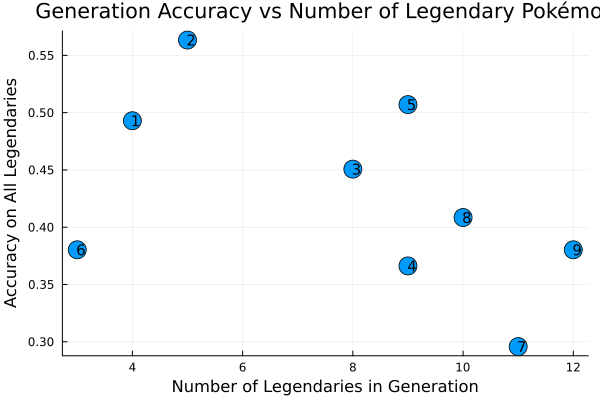

In [247]:
plot = scatter(
    summary_df.NumLegendaries,
    summary_df.Accuracy,
    xlabel = "Number of Legendaries in Generation",
    ylabel = "Accuracy on All Legendaries",
    title = "Generation Accuracy vs Number of Legendary Pokémon",
    marker = (:circle, 10),
    legend = false
)

for row in eachrow(summary_df)
    annotate!(plot, row.NumLegendaries, row.Accuracy, text(string(row.Generation), :left, 10))
end

display(plot)


In [249]:
### I am guessing the differences in average stats is higher in the earlier games, and games with less legendary Pokemon. Lets see it. 

In [251]:
#non legendary Pokemon dataframe
non_legendary_df = filter(row -> row.is_legendary == 0, df)

avg_leg = combine(groupby(legendary_df, :Generation), features .=> mean)




Row,Generation,hp_mean,attack_mean,defense_mean,sp_attack_mean,sp_defense_mean,speed_mean
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,94.0,96.25,91.25,124.75,97.5,101.25
2,2,103.4,99.0,99.0,99.0,119.6,100.0
3,3,88.125,99.375,117.5,108.125,126.25,80.625
4,4,99.0,107.222,109.0,110.0,110.111,92.4444
5,5,93.8889,118.222,92.3333,113.0,93.4444,102.444
6,6,120.0,120.667,103.667,114.333,97.0,97.6667
7,7,84.2727,91.8182,94.4545,93.6364,95.6364,80.5455
8,8,106.4,105.5,85.5,91.1,80.5,109.5
9,9,91.0833,102.0,92.25,93.5833,98.0833,98.4167


In [253]:
avg_non = combine(groupby(non_legendary_df, :Generation), features .=> mean)

Row,Generation,hp_mean,attack_mean,defense_mean,sp_attack_mean,sp_defense_mean,speed_mean
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,63.4014,71.5646,67.5306,65.2993,64.9592,67.9184
2,2,68.8526,66.6421,67.7263,62.3684,69.5368,59.3789
3,3,63.8583,71.4567,65.5591,64.811,62.3858,60.1024
4,4,70.7245,77.7347,72.0,69.9082,71.102,67.3673
5,5,68.7347,78.2789,69.7415,66.5646,65.5986,64.4014
6,6,66.4783,70.3333,73.9855,70.7246,73.7536,64.5797
7,7,69.1169,83.7662,76.4805,72.2857,71.5584,63.2078
8,8,66.6456,76.8608,71.1139,69.0127,67.7595,62.4684
9,9,77.0957,82.9043,75.4261,70.8348,69.9565,73.5826


In [264]:
#Merging the DFs 
merged = innerjoin(avg_leg, avg_non, on=:Generation,
                   makeunique=true)

Row,Generation,hp_mean,attack_mean,defense_mean,sp_attack_mean,sp_defense_mean,speed_mean,hp_mean_1,attack_mean_1,defense_mean_1,sp_attack_mean_1,sp_defense_mean_1,speed_mean_1
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,94.0,96.25,91.25,124.75,97.5,101.25,63.4014,71.5646,67.5306,65.2993,64.9592,67.9184
2,2,103.4,99.0,99.0,99.0,119.6,100.0,68.8526,66.6421,67.7263,62.3684,69.5368,59.3789
3,3,88.125,99.375,117.5,108.125,126.25,80.625,63.8583,71.4567,65.5591,64.811,62.3858,60.1024
4,4,99.0,107.222,109.0,110.0,110.111,92.4444,70.7245,77.7347,72.0,69.9082,71.102,67.3673
5,5,93.8889,118.222,92.3333,113.0,93.4444,102.444,68.7347,78.2789,69.7415,66.5646,65.5986,64.4014
6,6,120.0,120.667,103.667,114.333,97.0,97.6667,66.4783,70.3333,73.9855,70.7246,73.7536,64.5797
7,7,84.2727,91.8182,94.4545,93.6364,95.6364,80.5455,69.1169,83.7662,76.4805,72.2857,71.5584,63.2078
8,8,106.4,105.5,85.5,91.1,80.5,109.5,66.6456,76.8608,71.1139,69.0127,67.7595,62.4684
9,9,91.0833,102.0,92.25,93.5833,98.0833,98.4167,77.0957,82.9043,75.4261,70.8348,69.9565,73.5826


In [266]:
# Calculating differences in stats between legendary and non-legendary Pokemon by Generation.

for f in features
    merged[!, Symbol(f, "_diff")] = merged[!, Symbol(f, "_mean")] .- merged[!, Symbol(f, "_mean_1")]
end

diff_df = select!(merged, :Generation, r"diff")  

Row,Generation,hp_diff,attack_diff,defense_diff,sp_attack_diff,sp_defense_diff,speed_diff
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,30.5986,24.6854,23.7194,59.4507,32.5408,33.3316
2,2,34.5474,32.3579,31.2737,36.6316,50.0632,40.6211
3,3,24.2667,27.9183,51.9409,43.314,63.8642,20.5226
4,4,28.2755,29.4875,37.0,40.0918,39.0091,25.0771
5,5,25.1542,39.9433,22.5918,46.4354,27.8458,38.0431
6,6,53.5217,50.3333,29.6812,43.6087,23.2464,33.087
7,7,15.1558,8.05195,17.974,21.3506,24.0779,17.3377
8,8,39.7544,28.6392,14.3861,22.0873,12.7405,47.0316
9,9,13.9877,19.0957,16.8239,22.7486,28.1268,24.8341


In [276]:
#Summing the stat columns 
stat_cols = names(diff_df)[2:end] 
diff_df.TotalDiff = vec(sum(Matrix(diff_df[:, stat_cols]), dims=2))

9-element Vector{Float64}:
 204.32653061224488
 225.49473684210525
 231.8267716535433
 198.94104308390018
 200.01360544217687
 233.47826086956525
 103.94805194805194
 164.6392405063291
 125.61666666666666

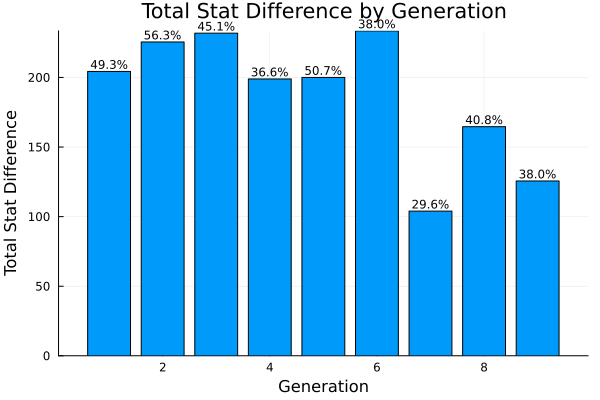

In [300]:
#Adding accuracies to the diff_df
diff_df.Accuracy = accuracies

#Barplot with each 
plot2 = @df diff_df bar(:Generation, :TotalDiff,
    xlabel = "Generation",
    ylabel = "Total Stat Difference",
    title = "Total Stat Difference by Generation",
    legend = false)

for (x, y, acc) in zip(diff_df.Generation, diff_df.TotalDiff, diff_df.Accuracy)
    annotate!(x, y + 5, text("$(round(acc*100, digits=1))%", :center, 8))
end

display(plot2)

In [ ]:
### Overall larger average stat differences between legendary and non-legendary Pokemon seem to have roughly the same loose correlation 
### as total legendary Pokemon. In both cases Generation 6 is a major outlier. 